# **UCB W207 Final Project**

## Using Machine Learning to Predict Executive Gender Pay Gaps 

Section 3
18 April 2023

Tess Cotter, Claudia Lokody Durkin, Jessica Matthews



# Introduction: Problem Motivation

“Women are underrepresented in the corporate business world and the top of the income distribution more generally, where relatively large gender wage gaps remain.”
(Blau and Kahn, 2017; Goldin 2014, Guvene et al., 2020).

The World Economic Forum projected that it would take 151 years to close the gender pay gap. Many companies have claimed that making progress on pay equity is a priority. Executives are often the most powerful and visible points at which to understand. Limited progress at equity at the top raises even more significant questions of what might be true for people with less leverage and publicity. Utilizing the public SEC dataset focused on executive compensation, we sought to understand gender-based variation, if any, among total compensation.

Executives are often the most powerful and visible points at which to understand. If there is little progress in pay equity, let alone representation at the top, that raises even more important questions of what might be true for employees throughout the company. 

Despite some progress and public interest in expanding gender equality in the workplace, pay disparities continue to persist. Organizations must address this issue and ensure all employees receive fair and equitable compensation. To understand the success of leadership and boards in addressing this at the executive level, we utilized an SEC dataset focused on executive compensation to understand gender-based variation, if any, in total compensation among executives. We also examine various analysis and machine learning techniques to predict executive pay gaps between men and women.

## Outline for our notebook

* Section 1: We import the data, the primary source being the US Securities Exchange Commission.
* Section 2: We undertake feature engineering and data cleaning. We note the data set is quite unbalanced, with 85% of the observations being male, and we rebalance the data set to be 50/50.
* Section 3: Simple exploratory data analysis is performed. We examine means and medians and, for the most part, find that there is always a gap between men and women, no matter the sector or position, the exception being female CEOS. 
* Section 4:  We build several models, starting from very simple, one feature (Gender), one layer to multi-layer, multi-feature, and using a transformer for categorical variables. 
* Section 5:  Discussion of the ethical considerations.
* Section 6:  Conclusions from our analysis. 

# Importing libraries 

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns 
sns.set(style="darkgrid") 
import plotly.graph_objs as plotly  
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

#setting  seed
#np.random.seed(100)

2023-04-17 20:34:21.682704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Section 1: Importing data

Our main data source is the US Securities Exchange Commission (SEC), Genderize.io, Yahoo Finance. The data are not processed. 

The features included year, Total (which denotes total compensation: a summation of salary, stock awards, option awards, non-equity incentive compensation and other compensation), Market Cap (stock price * shares outstanding), last and first names, sector (such a technology) and industry (a further classification of sector). 

The original data frame consists of 293,504 rows and 19 features.

In [2]:
# Split the text string of position to create First Name and Last Name Columns

# using APIs but API keys aren't provided, thus we comment out the code. 
#init_df['First_Name'] = init_df.Name.str.split(' ', expand = True)[0]
#init_df['Last_Name'] = init_df.Name.str.split(' ', expand = True)[1]
# init_df.head()

In [3]:
# Get gender based on list of first names

def get_gender(list_of_first_names): 
    """Takes in a list of names and makes queries in batches of 10 to generizer."""
    
    #headers = {'Authorization': f'token {os.environ["GENDERIZER_KEY"]}'}
    #authorization = f'&apikey={os.environ["API_KEY"]}'

    i = 0
    list_of_ten = []
    output_list = []
   
    for i in range(999): 
        list_of_ten.append(list_of_first_names[i])

        if len(list_of_ten) == 10:
            params = {'name': list_of_ten}
            r = requests.get('https://api.genderize.io/', params=params)
            gen_response = r.json()
            output_list.append(gen_response)
            list_of_ten = []
    

    return output_list

In [4]:
# Import data

url = "https://drive.google.com/uc?id=1R1YePQOlq9ZEF-oE-x1gc-vbOH5aQl9Q&export=download"
df = pd.read_csv(url)
display(df)


,Unnamed: 0,Unnamed: 0.1,CIK,Ticker,Name,Position,Year,Salary,Stock Awards,Option Awards,...,Other Compensation,Total,Last_Name,First_Name,assumed_gender,MarketCap,Sector,Industry,category,categorized_role
0,0,0,320193,AAPL,Jeff Williams,Chief Operating Officer,2021,1000000,21959620,0,...,17437,26977057,Williams,Jeff,male,2336261668864,Technology,Consumer Electronics,COO,COO
1,1,1,320193,AAPL,Tim Cook,Chief Executive Officer,2021,3000000,82347835,0,...,1386559,98734394,Cook,Tim,male,2336261668864,Technology,Consumer Electronics,CEO,CEO
2,2,2,320193,AAPL,Kate Adams,"Senior Vice President, General Counsel and Sec...",2021,1000000,21959620,0,...,14533,26974153,Adams,Kate,female,2336261668864,Technology,Consumer Electronics,GC,GC
3,3,3,320193,AAPL,Luca Maestri,"Senior Vice President, Chief Financial Officer",2021,1000000,21959620,0,...,18883,26978503,Maestri,Luca,male,2336261668864,Technology,Consumer Electronics,CFO,CFO
4,4,4,320193,AAPL,Deirdre O Brien,"Senior Vice President, Retail + People",2021,1000000,21959620,0,...,61191,27020811,O,Deirdre,female,2336261668864,Technology,Consumer Electronics,CHRO,CHRO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293499,293499,300108,36966,FHN,C. T. Tuggle,EVP & General Counsel,2008,470041,373400,0,...,388565,1670829,T.,T.,NaN,-1,Financial Services,Banks - Regional,GC,GC
293500,293500,300111,36966,FHN,T. C. Adams,EVP & Treasurer Former Interim CFO,2008,322676,67300,7451,...,19017,867870,C.,C.,NaN,-1,Financial Services,Banks - Regional,Other,Other
293501,293501,300113,36966,FHN,F. J. Gusmus,President–FTN Financial,2008,289846,0,0,...,17247,1524509,J.,J.,NaN,-1,Financial Services,Banks - Regional,CFO,CFO
293502,293502,300235,797468,OXY,R. Casey Olson,Executive Vice President,2008,480000,2797560,1343334,...,183057,5403951,Casey,Casey,male,-1,NaN,NaN,Other,Other


# Section 2: Feature engineering

The data required a great deal of cleaning. We noted several issues, including non-sensical values; for example, market capitilization, which is the price of the stock times the shares outstanding was -1 in some rows(impossible) or zero. We filtered the dataframe to remove any irrelevant values.

We also catergorized C-suite job titles and produced bins for salary ranges (which were extremely wide). We binarized male/females.  Lastly, we normalized data for market cap and total compensation. 

After cleaning, the dataframe has 18,081 rows and 24 features. There is a large skew towards men (85% of the rows) and thus we rebalance the data to be a 50/50 split.  After the rebalancing, the training and test dataframe has 2,662 rows each. 




In [5]:
# Code block for cleaning and feature engineering

print("Number of rows with nans = ", df[df.isna().any(axis=1)].Total.count())

# Dictionary of C-level job titles
c_level_titles = {'CEO': ['chief executive officer'], 
                  'COO': ['chief operating officer', 'operating', 'operations'], 
                  'CFO': ['chief financial officer', 'financial'], 
                  'CTO': ['chief technology officer', 'technology'], 
                  'CIO': ['chief information officer', 'chief innovation officer'], 
                  'CMO': ['chief marketing officer', 'head of marketing', 'marketing'],
                  'CHRO': ['chief human resources officer', 'chief people officer', 'people'],
                  'GC': ['general counsel', 'chief legal officer'], 
                  'CISO': ['chief information security officer', 'security'],
                  'CSO': ['chief sales officer', 'chief revenue officer', 'sales'],
                  'CDO': ['chief data officer', 'digital transformation officer', 'data', 'transformation']}

# Categorize job titles into C-level titles
for c_level_title, job_titles in c_level_titles.items():
    for job_title in job_titles:
        df.loc[df['Position'].str.lower().str.contains(job_title), 'category'] = c_level_title

# Fill NaN values with 'Other'
df['category'].fillna('Other', inplace=True)

# Updating dataframe to only use male and female and filter unspecified
df=df[(df.assumed_gender == 'male') | (df.assumed_gender == 'female')] 

# Updating dataframe with a binary male/female column
df["gender_boolean"] = 0  # zero is male 
df.loc[df.assumed_gender == 'female', "gender_boolean"] = 1

# Filter any compensation below $200,000 as there are data points that don't reflect annual salaries 
# For example, CEO worked only a month.
df = df[(df.Total >= 200000) & (df.Total <= 100000000)]

#bins for "Total" compensation
bins = [0, 250000,500000, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000, 11000000, 12000000, 13000000, 14000000, 15000000,
16000000, 17000000, 18000000, 19000000, 20000000, 30000000, 40000000, 50000000, 100000000]
df['BinnedCompensation'] = pd.cut(df.Total, bins)

# Given that some marketcap values are -1 and 0, filter for Market Cap above $100,000
df = df[df.MarketCap > 100000]

#normalize total compensation to be between 0 and 1
Total = np.log(df.Total) 
Total_norm = (Total-np.min(Total))/(np.max(Total)-np.min(Total))
df['Total_norm'] = Total_norm

# normalize MarketCap to be between 0 and 1
MarketCap = np.log(df.MarketCap)
MarketCap_norm = (MarketCap - np.min(MarketCap))/(np.max(MarketCap)-np.min(MarketCap))
df['MarketCap_norm'] = MarketCap_norm

# Filter for 2021 data only
df = df[df.Year == 2021]
print('This is the data frame head:', df.head())



Number of rows with nans =  25892
This is the data frame head:    Unnamed: 0  Unnamed: 0.1     CIK Ticker             Name  \
0           0             0  320193   AAPL    Jeff Williams   
1           1             1  320193   AAPL         Tim Cook   
2           2             2  320193   AAPL       Kate Adams   
3           3             3  320193   AAPL     Luca Maestri   
4           4             4  320193   AAPL  Deirdre O Brien   

                                            Position  Year   Salary  \
0                            Chief Operating Officer  2021  1000000   
1                            Chief Executive Officer  2021  3000000   
2  Senior Vice President, General Counsel and Sec...  2021  1000000   
3     Senior Vice President, Chief Financial Officer  2021  1000000   
4             Senior Vice President, Retail + People  2021  1000000   

   Stock Awards  Option Awards  ...  assumed_gender      MarketCap  \
0      21959620              0  ...            male  23362616

## Male/Female split before rebalancing 

As noted below, the data set is highly skewed towards male executives, with about 85% men and 15% women. 

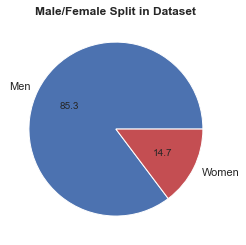

In [6]:
# Pie chart of female/male split in dataset
pie_chart_label_values = df['gender_boolean'].value_counts()
plt.pie(pie_chart_label_values, labels=['Men', 'Women'], colors = ['b', 'r'],autopct='%.1f')
plt.title("Male/Female Split in Dataset", fontweight = "bold")
plt.show()

### Train/test split and rebalance data by gender

To address the data imbalance, we rebalance the dataset. We further split the data into train and test sets


In [7]:
# Isolate genders to create 50/50 split
df_male = df[df['gender_boolean'] == 0]
df_female = df[df['gender_boolean'] == 1]

# Shuffle each
df_male = df_male.sample(frac=1)
df_female = df_female.sample(frac=1)

# Take the minimum number of the smallest gender to construct the sample size
min_samples = min(len(df_male), len(df_female))

# Create train and test dataframes with equal gender representation
train_samples = min_samples // 2
test_samples = min_samples - train_samples

df_train = pd.concat([df_male[:train_samples], df_female[:train_samples]])
df_test = pd.concat([df_male[train_samples:train_samples+test_samples], df_female[train_samples:train_samples+test_samples]])


print("Complete dataframe:",df.shape)
print("Train dataframe:", df_train.shape)
print("Test dataframe:", df_test.shape)



Complete dataframe: (18081, 25)
Train dataframe: (2662, 25)
Test dataframe: (2664, 25)


### Male/Female Split after Reblancing 

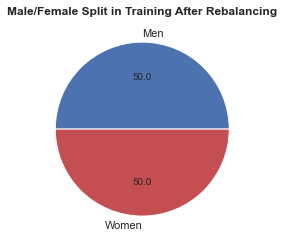

In [8]:
# Pie chart of female/male split in train dataset after rebalancing. 
pie_chart_label_values = df_train['gender_boolean'].value_counts()
plt.pie(pie_chart_label_values, labels=['Men', 'Women'], colors = ['b', 'r'],autopct='%.1f')
plt.title("Male/Female Split in Training After Rebalancing", fontweight = "bold")
plt.show()



# Section 3: Exploratory Data Analysis


Some findings from EDA:
 
*   US executives of large publicly-traded companies have very high total compensation, and the deviations are extremely large.
*   Very few women executives earning at the top compensation levels.
*  Female CEOs out earn males on average but no female CEOS earning top compensation



In [9]:
# Analyzing the numeric data after cleaning.
display(df.describe())

# Checking the data types
print("\n Datatypes of the features")
print(df.dtypes)

,Unnamed: 0,Unnamed: 0.1,CIK,Year,Salary,Stock Awards,Option Awards,Non-Equity Incentive Compensation,Other Compensation,Total,MarketCap,gender_boolean,Total_norm,MarketCap_norm
count,18081.000000,18081.000000,1.808100e+04,18081.0,1.808100e+04,1.808100e+04,1.808100e+04,1.808100e+04,1.808100e+04,1.808100e+04,1.808100e+04,18081.000000,18081.000000,18081.000000
mean,133784.438305,138625.268182,1.143340e+06,2021.0,5.195936e+05,1.941075e+06,6.308314e+05,5.789721e+05,2.402339e+05,4.171013e+06,1.413701e+10,0.147282,0.388628,0.554129
std,73973.664554,75148.116736,5.407898e+05,0.0,4.912657e+05,4.748813e+06,2.397346e+06,1.291114e+06,7.909838e+06,6.288534e+06,7.202412e+10,0.354396,0.176933,0.139690
min,0.000000,0.000000,1.750000e+03,2021.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+05,1.276140e+05,0.000000,0.000000,0.003465
25%,73482.000000,76524.000000,8.740150e+05,2021.0,3.250000e+05,0.000000e+00,0.000000e+00,0.000000e+00,7.380000e+03,1.027492e+06,2.809525e+08,0.000000,0.263458,0.462135
50%,134281.000000,139894.000000,1.180145e+06,2021.0,4.414500e+05,5.719600e+05,0.000000e+00,2.078850e+05,2.030000e+04,2.210464e+06,1.505204e+09,0.000000,0.386783,0.562160
75%,192376.000000,199853.000000,1.596967e+06,2021.0,6.150000e+05,1.901669e+06,3.064760e+05,6.457500e+05,6.594800e+04,4.711733e+06,6.110517e+09,0.000000,0.508624,0.645652
max,291987.000000,277717.000000,1.937653e+06,2021.0,3.149358e+07,1.193935e+08,8.473796e+07,5.242752e+07,1.046111e+09,9.873439e+07,2.336262e+12,1.000000,0.998394,1.000000



 Datatypes of the features
Unnamed: 0                              int64
Unnamed: 0.1                            int64
CIK                                     int64
Ticker                                 object
Name                                   object
Position                               object
Year                                    int64
Salary                                  int64
Stock Awards                            int64
Option Awards                           int64
Non-Equity Incentive Compensation       int64
Other Compensation                      int64
Total                                   int64
Last_Name                              object
First_Name                             object
assumed_gender                         object
MarketCap                               int64
Sector                                 object
Industry                               object
category                               object
categorized_role                       object
gender

## Analyzing Means and Median
We analyzed the means, medians, and standard deviations more closely.   We look at the data in different ways, splitting by positions and generally total compensation for men is slighy higher for women. 

Overall, the median total compensation for females is 1.94 million and for males, 2.26 million and the median salaries are 2.44 million and 2.94 million, respectively.  Interestingly, the mean female CEO total compensation is 5.2 million, greater than 5.0 million male compensation; however the standard deviation are quite large at around 6 and 7 million, respectively. In summary, US executives of large companies have very high total compensation, and the deviations are extremely large. 


In [10]:
# Analysing Medians and Means

print("\n\n")
print("Female: median total compensation:", (df[df.assumed_gender == 'female'].Total.median()))
print("Male: median total compensation", (df[df.assumed_gender == 'male'].Total.median()))
print("\n")
print("Female: mean total compensation:", round(df[df.assumed_gender == 'female'].Total.mean(),1))
print("Male: mean total compensation:", round(df[df.assumed_gender == 'male'].Total.mean(),1))

print("Median female CEO", (df[(df.assumed_gender == 'female') & (df.category == 'CEO')].Total.median()))
print("Median male CEO", (df[(df.assumed_gender == 'male') & (df.category == 'CEO')].Total.median()))

# REMOVING THE BELOW 100K SALARIES

print("Median female CEO %d" % (df[(df.assumed_gender == 'female') & (df.category == 'CEO') & (df.Total > 100000)].Total.median()))
print("Median male CEO %d" % (df[(df.assumed_gender == 'male') & (df.category == 'CEO') & (df.Total > 100000)].Total.median()))

print("Average female CEO %d" % (df[(df.assumed_gender == 'female') & (df.category == 'CEO') & (df.Total > 100000)].Total.mean()))
print("Average male CEO %d" % (df[(df.assumed_gender == 'male') & (df.category == 'CEO') & (df.Total > 100000)].Total.mean()))

#  Standard deviations
print("Std deviation female CEO %d" % (df[(df.assumed_gender == 'female') & (df.category == 'CEO') & (df.Total > 100000)].Total.std()))
print("Std deviation male CEO %d" % (df[(df.assumed_gender == 'male') & (df.category == 'CEO') & (df.Total > 100000)].Total.std()))






Female: median total compensation: 1942357.0
Male: median total compensation 2261540.5


Female: mean total compensation: 3562709.2
Male: mean total compensation: 4276079.4
Median female CEO 4365748.0
Median male CEO 4582324.0
Median female CEO 4365748
Median male CEO 4582324
Average female CEO 6420030
Average male CEO 7048448
Std deviation female CEO 6876065
Std deviation male CEO 8715016


# Histograms to analyze data

There is a large spread in compensation, ranging from around 250,000 to 100 million. We noted that most of the compensation is clustered around the lower end of compensation and we analyze by select positions, with CEOs male earning the most and with the largest range in compensation. 

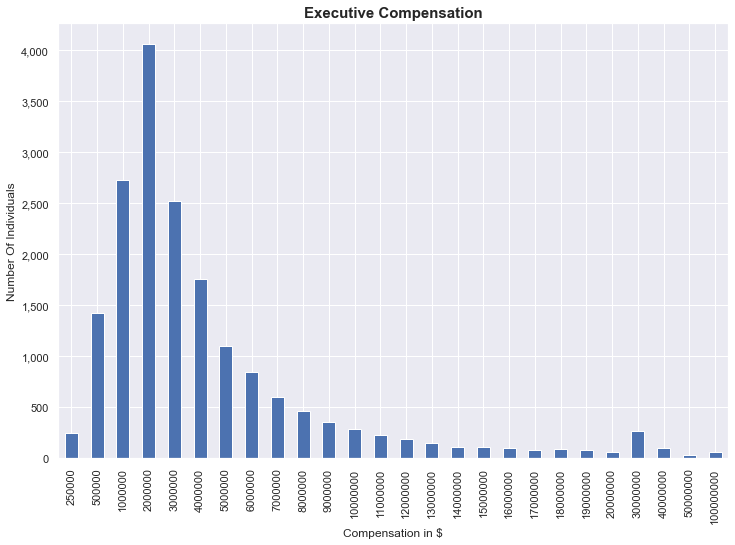

In [11]:
# Plot the histogram of the numbers within the buckets (using the top value of the range)

ax = df.BinnedCompensation.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,8))
ax.set_title ("Executive Compensation", fontweight = "bold", fontsize = 15)
ax.set_xticklabels(bins[1:], rotation=90)
ax.set_xlabel("Compensation in $")
ax.set_ylabel("Number Of Individuals")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.4f}'))
plt.show()

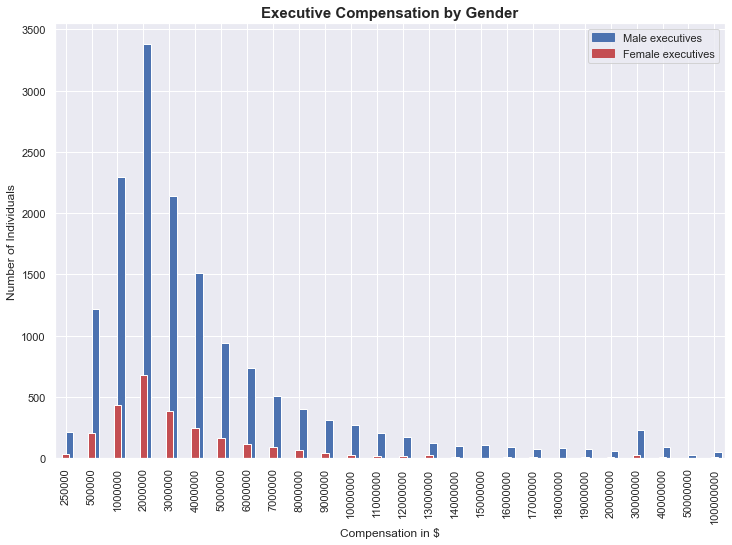

In [12]:
# Plot the histogram of the numbers within the income buckets (binned_compensation) based on gender 

N = 25
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(5,5))

# Width of a bar 
width = 0.3 

# Plots
ax = df[df.assumed_gender == 'male'].BinnedCompensation.value_counts(sort=False).plot.bar(rot=0, width = width, align = "edge", color="b",figsize=(12,8))
ax1 = df[df.assumed_gender == 'female'].BinnedCompensation.value_counts(sort=False).plot.bar(rot=0,width = width, align = "center",color="r",figsize=(12,8))

# Formating 

ax.set_xticklabels(bins[1:], rotation=90)
ax.set_title ("Executive Compensation by Gender", fontweight = "bold", fontsize = 15)
ax.set_xlabel("Compensation in $")
ax.set_ylabel("Number of Individuals")
men = mpatches.Patch(color='b', label='Male executives')
women = mpatches.Patch(color='r', label='Female executives')
plt.legend(handles=[men, women])
plt.savefig("comp_by_gender.png")
plt.show()


Text(0.5, 1.0, 'Male CTOs')

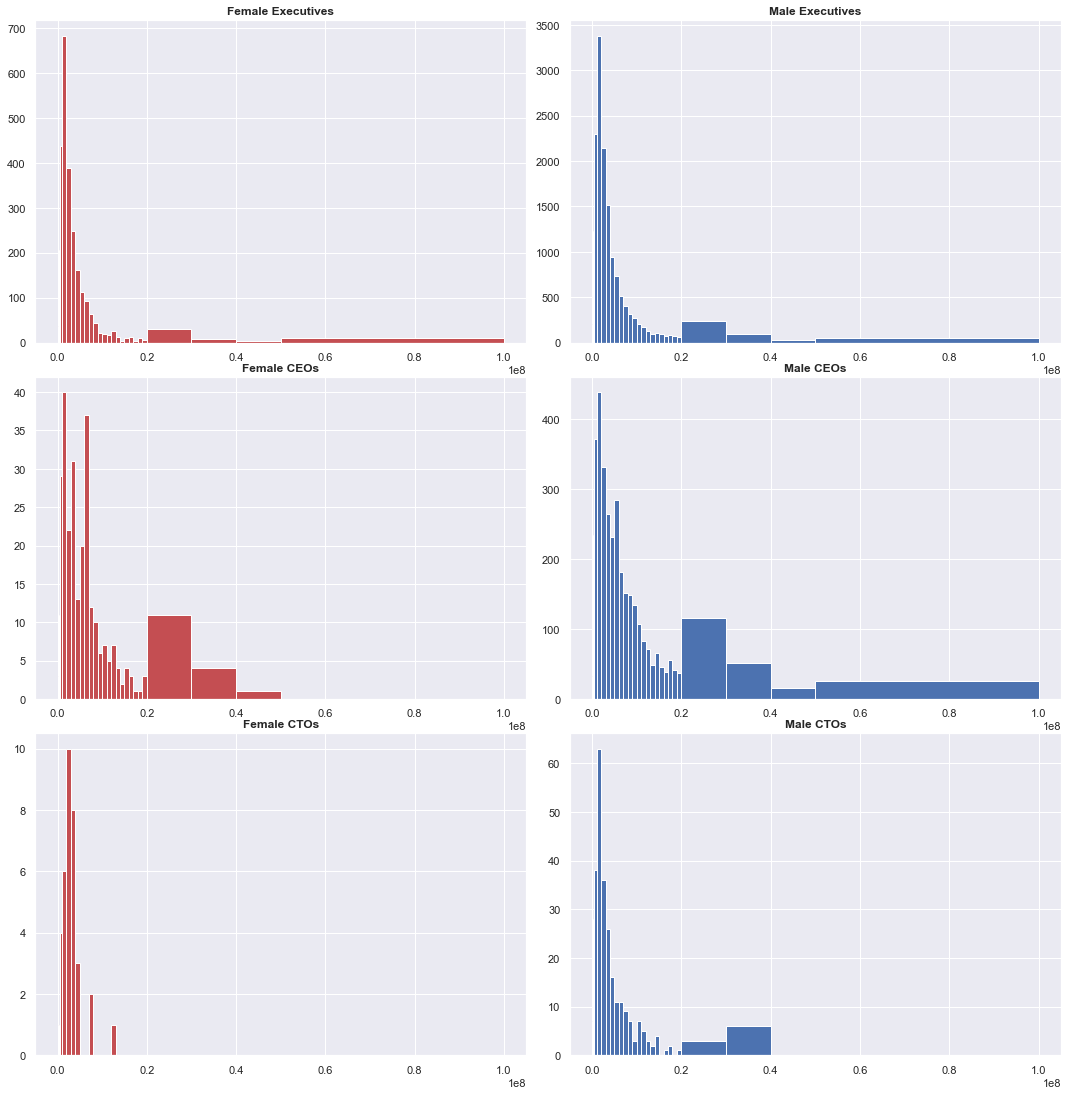

In [13]:
# Histograms by gender, executives 
fig, axs = plt.subplots(3, 2, figsize = (15,15))
fig.tight_layout()

axs[0, 0].hist(df[(df.assumed_gender == 'female')].Total, bins = bins, color = 'r')
axs[0, 0].set_title('Female Executives', fontweight = 'bold')

axs[0, 1].hist(df[(df.assumed_gender == 'male')].Total, bins = bins)
axs[0, 1].set_title('Male Executives', fontweight = 'bold')

axs[1, 0].hist(df[(df.assumed_gender == 'female') & (df.category == 'CEO')].Total, bins = bins, color = 'r')
axs[1, 0].set_title('Female CEOs', fontweight = 'bold')

axs[1, 1].hist(df[(df.assumed_gender == 'male') & (df.category == 'CEO')].Total, bins = bins)
axs[1, 1].set_title('Male CEOs', fontweight = 'bold')

axs[2, 0].hist(df[(df.assumed_gender == 'female') & (df.category == 'CTO')].Total, bins = bins, color = 'r')
axs[2, 0].set_title('Female CTOs', fontweight = 'bold')

axs[2, 1].hist(df[(df.assumed_gender == 'male') & (df.category == 'CTO')].Total, bins = bins)
axs[2, 1].set_title('Male CTOs', fontweight = 'bold')



### Pairwise correlations

We run pairwise correlations but find this less useful as total compensation is a sum of salary, stock awards, other compensation. Notably, market cap (a proxy for firm size) has a 0.28 correlation with total compensation. 

Other interpretations:

*   We ran pairwise correlation coefficients on all the features, but not did find anything significant.

*  The gender_boolen feature does not seem to be correlated with other features (slightly negative but near zero).

* Market cap (referring to the size of the publicly-traded company) has a slightly positive correlation (0.26) to total compensation, suggesting that larger companies may have larger executive compensation packages



In [14]:
# Pairwise correlations.
# Note to grader, this block took a while to run and didn't add much to our analysis so it's been commented out. 
#sns.pairplot(df_train) 
#df_train.corr()

# Section 4: Model building and predictions.

We build a simple model to start, using 1 feature, gender and one layer (model 1).  We then add on other features and multi layers (model2, model3 and model4). In Model5, we use a one-hot encoding to transform the catergorical variable, sector and run a multi-layer 12 feature model. 

## Functions used in model building

In [15]:
# This code block contains all the functions used to build the models. 

#Function creates a model with hyperparameters and 1 layer

def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. 
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model


 #Function creates a model with multi hyperparameters

def build_model_multi(num_features, learning_rate, hidden_layer_sizes=[], activation = "relu"):
  """Build a TF Neural Network Model using Keras with hidden layers

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. 
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  #hidden layer
  for size in hidden_layer_sizes:
    model.add(keras.layers.Dense(size, activation = activation))
  

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model


def show_history(history, title):
  """Plot the loss at each epoch and show final numbers. Train simple model"""
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='dev')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title(title, fontweight = 'bold', fontsize = 14)
  plt.legend()
  plt.show()


def unnormalize_total(x):
  """ This function takes the normalized result from predict and converts it
  back to the dollar level. For example market_cap_norm had a log function applied
  and converted to values between 0 and 1 and this returns a dollar amount."""

  Total = np.log(df.Total)
  result = (x * (np.max(Total)-np.min(Total)) + np.min(Total))
  return np.exp(result)

def unnormalize_total(x):
  """ This function takes the normalized Total compensatation from predict and converts it
    back to the dollar level. For example, total compensation had a log function applied
    and converted to values between 0 and 1 and this returns a dollar amount."""

  Total = np.log(df.Total)
  result = (x * (np.max(Total)-np.min(Total)) + np.min(Total))
  return np.exp(result)


def model_return_prediction(gender_b, MarketCap_n, model_name):
    """This function unnormalizes model predictions """
    return unnormalize_total(model_name.predict([[gender_b, MarketCap_n]])[0][0])


## Model 1: One feature, gender
We train a simple model with one feature, gender. We experiment with different learning rates and optimizer and find that learning rate = 0.01 and optimizer Adam has the lowest loss and validation loss and best convergence. Our model predicts that males have higher compensation than females (1.6 million  vs 1.4 million, respectively). 

2023-04-17 20:35:04.040048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,loss,val_loss
0,0.574236,0.230365
1,0.059340,0.036042
2,0.036692,0.028788
3,0.032654,0.026369
4,0.031088,0.025417
5,0.030644,0.025304


Weights: [[-0.00120073]]
Biases: [0.37437963]


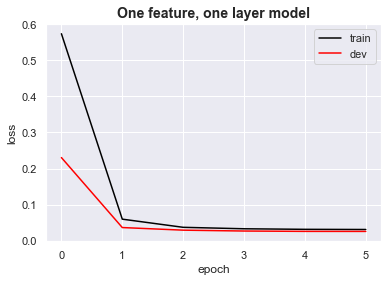

In [16]:
#MODEL 1: One feature, gender and one layer. 
model1 = build_model(num_features=1, learning_rate=0.01)

X = np.asarray(df_train.gender_boolean)
X_test = np.asarray(df_test.gender_boolean)
Y = np.asarray(df_train.Total_norm)
Y_test = np.asarray(df_test.Total_norm)

#Train the model
history1 = model1.fit(
  x = X,
  y = Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=6,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').

display(pd.DataFrame(history1.history))

# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model1.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

# Plotting the loss function
show_history(history1, "One feature, one layer model")


In [17]:
# Calculating RMSE for model 1
Y_pred = model1.predict(X_test)

#print("Y_pred shape:", Y_pred.shape)
# Squeeze Y_pred to remove singleton dimensions
Y_pred = Y_pred[:,0]
#print("Y_pred shape:", Y_pred.shape)

# Calculate squared differences for each predicted value
squared_diff = (Y_pred - Y_test) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse1 = np.mean(rmse)

print("Average RMSE:", average_rmse1)

84/84 [==============================] - 0s 1ms/step
Average RMSE: 0.17214512970617524


## Tuning Hyperparameters

We experiment with different optimizers and learning rates.  We find that Adam optimizer plus learning rate of 0.01 has the best convergence of the loss and validation loss.


Model | Optimizer | Learning rate | Loss | Val Loss
-|-|-|-|-|
Model 1: Gender|SGD|0.01|0.046|0.049|
Model 1: Gender|SGD|0.001|0.700|1.344|
Model 1: Gender|SGD|0.0001|1.476|2.801|
Model 1: Gender|Adam|0.01|0.0359|0.0362|
Model 1: Gender|Adam|0.001|1.038|1.934|

## Model 1 predictions

Recall that 0 = male, and 1 = female. Results are normalized, and we create   function unnormalize_total converts the numbers back to dollar values. The model predicts that a male executive salary is 2.12279 million dollarsand female salary is 2.0608 million dollars

In [18]:
# male = 0, female = 1
predict_1_m = model1.predict([[0]])
predict_1_f = model1.predict([[1]])
print(predict_1_m[0])
# function to convert normalized predictions back to dollars


# Printing the results, and converting to millions

print("Prediction of male salary: ", "$",round(unnormalize_total(predict_1_m[0][0])/1000000,4), "million")
print("Prediction of female salary: ", "$", round(unnormalize_total(predict_1_f[0][0])/1000000,4), "million")

1/1 [==============================] - 0s 55ms/step
[0.37437963]
Prediction of male salary:  $ 2.0389 million
Prediction of female salary:  $ 2.0238 million


## Additional analysis as a sanity check: Simple OLS regression
We run a simple OLS regression to get a better sense of the relationship between gender and compensation. We find a slight downward sloping regression curve, indicating slighly lower compensation for females vis-a-vis males, confirming our earlier exploratory analysis. The correlation coefficient between gender and normalized total compensation is slightly negative at -0.08.  


84/84 [==============================] - 0s 921us/step


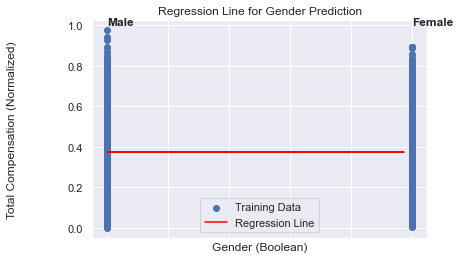

In [19]:
# Plot the scatter plot of training data
plt.scatter(df_train.gender_boolean, df_train.Total_norm, label='Training Data')

# Generate predicted values for the regression line
predicted_values = model1.predict(df_train[['Total_norm']])

  
# Adding space between label and
# axis by setting labelpad
plt.ylabel('Numbers label', labelpad = 50)

# Plot the regression line
plt.plot(df_train.Total_norm, predicted_values, color='red', label='Regression Line')

# Add labels and title
plt.xlabel('Gender (Boolean)')

plt.ylabel('Total Compensation (Normalized)')
plt.title('Regression Line for Gender Prediction')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.text(0, 1, 'Male', fontsize = 12, fontweight = 'bold')
plt.text(1, 1, 'Female', fontsize = 12,fontweight = 'bold')
#

# Add legend
plt.legend()

# Display the plot
plt.show()

## Model 2: Two features: gender and  market cap, single layer

We expand the simple model to include market cap (a measure of a company's size). For mid-size companies, men earn 1.1 million and women earn 960,000 For large-size companies, male executives earn 6.37 million and females 5.56 million. The chart below shows an increasing total compensation gap. 

,loss,val_loss
0,1.195462,0.428372
1,0.082629,0.037233
2,0.030618,0.024035
3,0.027051,0.021216
4,0.025279,0.019734
5,0.024452,0.019165
6,0.024023,0.018860
7,0.023721,0.018504
8,0.023507,0.018268
9,0.023250,0.018073


Weights: [[-0.0266033 ]
 [ 0.38607174]]
Biases: [0.17680272]


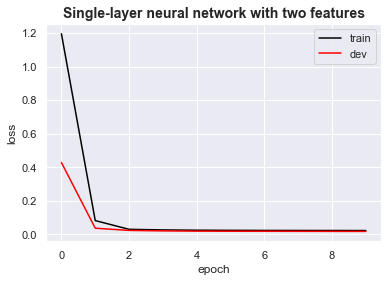

In [20]:
#MODEL 2: Two features, gender and market cap and single layer. 

model2 = build_model(num_features=2, learning_rate=0.01)

X = np.asarray(df_train[['gender_boolean','MarketCap_norm']])
X_test = np.asarray(df_test[['gender_boolean','MarketCap_norm']])
Y = np.asarray(df_train.Total_norm)
Y_test = np.asarray(df_test.Total_norm)

#Train the model
history2 = model2.fit(
  x = X,
  y = Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').

display(pd.DataFrame(history2.history))


# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model2.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

# Run funtion to show the history
show_history(history2, "Single-layer neural network with two features")

In [21]:
# Calculating RMSE for model 2
Y_pred = model2.predict(X_test)

print("Y_pred shape:", Y_pred.shape)
# Squeeze Y_pred to remove singleton dimensions
Y_pred = Y_pred[:,0]
print("Y_pred shape:", Y_pred.shape)

# Calculate squared differences for each predicted value
squared_diff = (Y_pred - Y_test) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse2 = np.mean(rmse)

print("Average RMSE:", average_rmse2)

84/84 [==============================] - 0s 943us/step
Y_pred shape: (2664, 1)
Y_pred shape: (2664,)
Average RMSE: 0.14861784603380246


## Model 2 Predictions

Using model 2, two features and single layer neutral network, we find that male executives in large companies are predicted to earn about 6.37 million dollars and female executives 5.56  million dollars. 

84/84 [==============================] - 0s 811us/step


/var/folders/n0/d70zymq16ygg9pq3qdwl5_n00000gn/T/ipykernel_66544/1742379632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2_predict_test["Predicted_Total_Test"] = [unnormalize_total(x) for x in model2_predictions[:,0]]


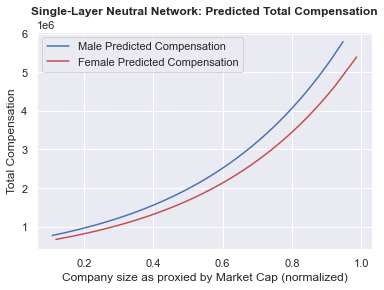

In [22]:
# Create a dataframe of the predictions to use for the plots
df_model2_predict_test = pd.DataFrame()
df_model2_predict_test = df_test[['gender_boolean', 'MarketCap_norm']]
model2_predictions = model2.predict(df_model2_predict_test)
# take the first column from the predictions generated and unnormalize them in a list comprehension
df_model2_predict_test["Predicted_Total_Test"] = [unnormalize_total(x) for x in model2_predictions[:,0]]
df_model2_predict_test = df_model2_predict_test.sort_values(by=['MarketCap_norm'], ascending=True)

# Plot of the predictions 

x1 = df_model2_predict_test[df_model2_predict_test.gender_boolean == 0]["MarketCap_norm"]
y1 = df_model2_predict_test[df_model2_predict_test.gender_boolean == 0]["Predicted_Total_Test"]

#line 1
plt.plot(x1, y1, label = "Male Predicted Compensation")

# line 2 points
x2 = df_model2_predict_test[df_model2_predict_test.gender_boolean == 1]["MarketCap_norm"]
y2 = df_model2_predict_test[df_model2_predict_test.gender_boolean == 1]["Predicted_Total_Test"]


# plotting the line 2 points 
plt.plot(x2, y2, label = "Female Predicted Compensation", color ="r")
plt.xlabel('Company size as proxied by Market Cap (normalized)')
# Set the y axis label of the current axis.
plt.ylabel('Total Compensation')
# Set a title of the current axes.
plt.title('Single-Layer Neutral Network: Predicted Total Compensation', fontweight ="bold")
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


## Model 3: Multilayer neural network, two features

We used a multilayer neural network, adding in hidden_layers and relu activation. Training and validation loss shows better convergence. Predictions are similiar to single-layer model, showing a pay gap as company size increases. For large companies, the model predicts a male compensation of 6.16 million dollars and for females 5.26 million dollars. 


,loss,val_loss
0,0.085318,0.071494
1,0.075971,0.067108
2,0.073579,0.061222
3,0.066944,0.056249
4,0.064055,0.055242
5,0.063914,0.055338
6,0.064304,0.058046
7,0.065789,0.055356
8,0.063581,0.055518
9,0.062899,0.052563


Weights: [[-0.05104776]
 [ 1.7630605 ]]
Biases: [0.5734608]


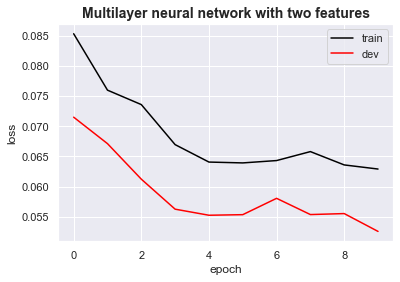

In [23]:
#MODEL 3: 2 features gender and market cap, and adding multiple layers

model3 = build_model_multi(num_features=2,learning_rate=0.01,hidden_layer_sizes=[256,128])

X = np.asarray(df_train[['gender_boolean','MarketCap_norm']])
X_test = np.asarray(df_test[['gender_boolean','MarketCap_norm']])
Y = np.asarray(df_train.Total_norm)
Y_test = np.asarray(df_test.Total_norm)

#Train the model
history3 = model3.fit(
  x = X,
  y = Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
display(pd.DataFrame(history3.history))


# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model3.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)


show_history(history3,"Multilayer neural network with two features")






In [24]:
# Calculating RMSE for model 3
Y_pred = model3.predict(X_test)

print("Y_pred shape:", Y_pred.shape)
# Squeeze Y_pred to remove singleton dimensions
Y_pred = Y_pred[:,0]
print("Y_pred shape:", Y_pred.shape)

# Calculate squared differences for each predicted value
squared_diff = (Y_pred - Y_test) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse3 = np.mean(rmse)

print("Average RMSE:", average_rmse3)

84/84 [==============================] - 0s 1ms/step
Y_pred shape: (2664, 128)
Y_pred shape: (2664,)
Average RMSE: 0.14296134776751004


84/84 [==============================] - 0s 1ms/step


/var/folders/n0/d70zymq16ygg9pq3qdwl5_n00000gn/T/ipykernel_66544/2275043255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model3_predict_test["Predicted_Total_Test"] = [unnormalize_total(x) for x in model3_predictions[:,0]]


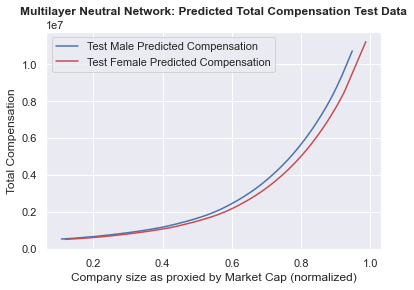

In [25]:
# Save predictions to dataframe, creating values for graphs

df_model3_predict_test = pd.DataFrame()
df_model3_predict_test = df_test[['gender_boolean','MarketCap_norm']]
model3_predictions = model3.predict(df_model3_predict_test)

# take the first column from the predictions generated and unnormalize them in a list comprehension
df_model3_predict_test["Predicted_Total_Test"] = [unnormalize_total(x) for x in model3_predictions[:,0]]


# Plot of the predictions 

# Need to sort the values since they are not in order
sorted_df = df_model3_predict_test.sort_values(by=['MarketCap_norm'], ascending=True)


x1_test = sorted_df[sorted_df.gender_boolean == 0]["MarketCap_norm"]
y1_test = sorted_df[sorted_df.gender_boolean == 0]["Predicted_Total_Test"]

#line 1
plt.plot(x1_test, y1_test, label = "Test Male Predicted Compensation")

# line 2 points

x2_test = sorted_df[sorted_df.gender_boolean == 1]["MarketCap_norm"]
y2_test = sorted_df[sorted_df.gender_boolean == 1]["Predicted_Total_Test"]

# plotting the line 2 points 
plt.plot(x2_test, y2_test, label = "Test Female Predicted Compensation", color ="r")

plt.xlabel('Company size as proxied by Market Cap (normalized)')
# Set the y axis label of the current axis.
plt.ylabel('Total Compensation')
# Set a title of the current axes.
plt.title('Multilayer Neutral Network: Predicted Total Compensation Test Data', fontweight ="bold")
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [26]:
# Using L2 regularization to boost accuracy
# Create an instance of Ridge model with regularization strength alpha
ridge_model4 = Ridge(alpha=1.0)

# Train the Ridge model using training data
ridge_model4.fit(X, Y)

# Predict using the trained Ridge model
y_pred = ridge_model4.predict(X_test)

# Evaluate the Ridge model using appropriate evaluation metrics
# (e.g., mean squared error for regression or accuracy for classification)
mse = mean_squared_error(Y_test, y_pred)

# Access the learned coefficients (parameters) of the Ridge model
coefficients = ridge_model4.coef_
print(coefficients)

[-0.02268213  0.67124544]


In [27]:
# Find feature importance based on coef
X = pd.DataFrame(df_train[['gender_boolean','MarketCap_norm', 'Sector', 'category']])
importance_scores = ridge_model4.coef_
feature_names = X.columns

In [28]:
# Find and sort features
importance_indices = importance_scores.argsort()[::-1]
sorted_importance_scores = importance_scores[importance_indices]
sorted_feature_names = feature_names[importance_indices]

In [29]:
# calculate R squared
actual_values = np.asarray(df_test['Total_norm']) # Actual accuracy values
predicted_values = np.array(y_pred)  # Predicted accuracy values

# Calculate accuracy values
accuracy = actual_values

# Calculate predictions values
predictions = predicted_values

# Calculate R-squared value
r2 = r2_score(accuracy, predictions)

# Print accuracy, predictions, and R-squared value
print("Accuracy values:", accuracy)
print("Predictions values:", predictions)
print("R-squared value:", r2)


r2 = r2_score(accuracy, predictions)

Accuracy values: [0.73024145 0.55380178 0.61287369 ... 0.44814115 0.89267252 0.39747684]
Predictions values: [0.44812423 0.42521213 0.57586479 ... 0.35565956 0.41507274 0.26764764]
R-squared value: 0.31315609732667493


In [30]:
# Calculating RMSE for ridge model 
Y_pred = ridge_model4.predict(X_test)


# Calculate squared differences for each predicted value
squared_diff = (Y_pred - Y_test) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse_ridge = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse = np.mean(rmse_ridge)


actual_values = np.asarray(df_test['Total_norm']) # Actual accuracy values
predicted_values = np.array(Y_pred)  # Predicted accuracy values

# Calculate accuracy values
accuracy = actual_values

# Calculate predictions values
predictions = predicted_values


# Print accuracy, predictions, and RMSE
print("Accuracy values:", accuracy)
print("Predictions values:", predictions)
print("RMSE:", average_rmse)

Accuracy values: [0.73024145 0.55380178 0.61287369 ... 0.44814115 0.89267252 0.39747684]
Predictions values: [0.44812423 0.42521213 0.57586479 ... 0.35565956 0.41507274 0.26764764]
RMSE: 0.14258968174108508


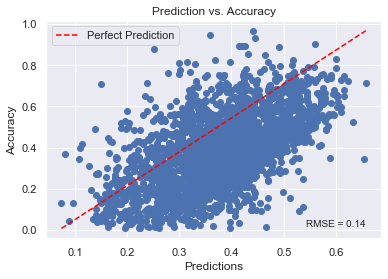

In [31]:
# Plot prediction vs. accuracy with a diagonal line and R-squared value
plt.scatter(predictions, accuracy)
plt.xlabel('Predictions')
plt.ylabel('Accuracy')
plt.title('Prediction vs. Accuracy')
plt.plot([min(predictions), max(predictions)], [min(accuracy), max(accuracy)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.text(max(predictions), min(accuracy), f'RMSE = {average_rmse:.2f}', ha='right', va='bottom')
plt.show()

In [32]:
# Double checking calculation RMSE for Ridge model

# Calculate squared differences for each predicted value
squared_diff = (predictions - accuracy) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse_ridge = np.mean(rmse)

print("Average RMSE:", average_rmse_ridge)

Average RMSE: 0.14258968174108508


# Model 4: Multi-layer neutral network, using catergorical data, transformed with integer encoding 

We wanted to look collectively at how gender, position, industry, and market capitalization can predict total compensation. 
The sectors are defined as the Global Industry Classifications Standards (GICS, a standard classification method for publically-traded companies.  We find that market capitalization has a large impact on compensation. 

In [33]:
# dataframe encoding for model 4
# convert to str to find unique values
df_train['Sector_n'] = df_train['Sector'].apply(str)
df_test['Sector_n'] = df_test['Sector'].apply(str)
print(np.unique(df_train['Sector_n']))

df_train['category_n'] = df_train['category'].apply(str)
df_test['category_n'] = df_test['category'].apply(str)

#Translate unique sector strings to int
# List of unique sector values
sector_values = ['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive',
                 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology',
                 'Utilities', 'nan']

# Create a dictionary to map sector values to integers
sector_to_int = {sector: i for i, sector in enumerate(sector_values)}

# Function to map sector values to integers
def map_sector_to_int(sector):
    if sector in sector_to_int:
        return sector_to_int[sector]
    else:
        # Assign a default value (e.g., -1) for unknown sectors or 'nan'
        return -1

# Map sector values to integers in the DataFrame
df_train['Sector_n'] = df_train['Sector'].map(map_sector_to_int)
df_test['Sector_n'] = df_test['Sector'].map(map_sector_to_int)

#df_train.head()


['Basic Materials' 'Communication Services' 'Consumer Cyclical'
 'Consumer Defensive' 'Energy' 'Financial Services' 'Healthcare'
 'Industrials' 'Real Estate' 'Technology' 'Utilities' 'nan']


In [34]:
# Convert role (category) values to int
category_values = ['CDO', 'CEO', 'CFO', 'CHRO', 'CIO', 'CISO', 'CMO', 'COO', 'CSO', 'CTO', 'GC', 'Other']

# Create a dictionary to map category values to integers
category_to_int = {category.upper(): i for i, category in enumerate(category_values)}

# Function to map category values to integers
def map_category_to_int(category):
    if category in category_to_int:
        return category_to_int[category]
    else:
        # Assign a default value (e.g., -1) for unknown categories or 'NaN'
        return -1

# Map category values to integers in the DataFrame
df_train['category_n'] = df_train['category_n'].str.upper().map(map_category_to_int)
df_test['category_n'] = df_test['category_n'].str.upper().map(map_category_to_int)
df_train.head()


,Unnamed: 0,Unnamed: 0.1,CIK,Ticker,Name,Position,Year,Salary,Stock Awards,Option Awards,...,Sector,Industry,category,categorized_role,gender_boolean,BinnedCompensation,Total_norm,MarketCap_norm,Sector_n,category_n
156052,156052,167610,917470,ZEUS,Richard A. Manson,Chief Financial Officer,2021,425000,0,0,...,Financial Services,Banks - Regional,CFO,CFO,0,"(2000000, 3000000]",0.377407,0.498625,5,2
77562,77562,83528,8858,AVT,Max Chan,Chief Information Officer,2021,360000,400915,0,...,Consumer Defensive,Packaged Foods,CIO,CIO,0,"(1000000, 2000000]",0.274703,0.619741,3,4
161887,161887,173758,813298,DXLG,Robert S. Molloy,General Counsel and Secretary,2021,375000,93122,49218,...,Real Estate,Real Estate - Development,GC,GC,0,"(500000, 1000000]",0.255908,0.487352,8,10
258522,258522,276789,1445283,YMTX,"Richard Peters, M.D.",Ph.D. Chief Executive Officer,2021,618000,1358370,2239770,...,Technology,Scientific & Technical Instruments,CEO,CEO,0,"(4000000, 5000000]",0.501016,0.313649,9,1
196584,196584,210681,8146,ALOT,Michael J. Natalizia,Chief Technology Officer and Vice President of...,2021,219725,111761,0,...,Consumer Cyclical,Lodging,CTO,CTO,0,"(250000, 500000]",0.098480,0.396097,2,9


,loss,val_loss
0,0.156763,0.125959
1,0.140176,0.124696
2,0.140203,0.124599
3,0.139411,0.121996
4,0.134622,0.118138
5,0.128791,0.111520
6,0.123028,0.105606
7,0.108742,0.093879
8,0.105868,0.094421
9,0.104628,0.091996


Weights: [[0.82441443]
 [0.7672879 ]
 [0.78676295]
 [0.8456559 ]]
Biases: [0.8544225]


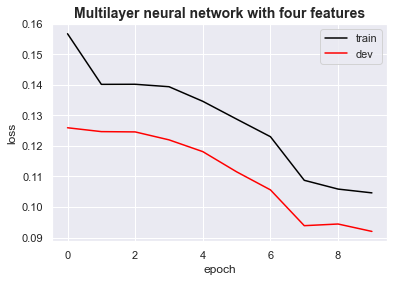

In [35]:
#MODEL 4: 2 features,  gender, market cap, sector, and role--adding multiple layers

model4 = build_model_multi(num_features=4,learning_rate=0.01,hidden_layer_sizes=[256,128])
#X = np.asarray(X).astype(np.float32)
X = np.asarray(df_train[['gender_boolean','MarketCap_norm', 'Sector_n', 'category_n']]).astype(np.float32)
X_test = np.asarray(df_test[['gender_boolean','MarketCap_norm', 'Sector_n', 'category_n']]).astype(np.float32)
Y = np.asarray(df_train.Total_norm)
Y_test = np.asarray(df_test.Total_norm)

#Train the model
history4 = model4.fit(
  x = X,
  y = Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
#history = pd.DataFrame(history.history)
display(pd.DataFrame(history4.history))


# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model4.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)


show_history(history4,"Multilayer neural network with four features")

In [36]:
# Calculating RMSE for model 4
#X_test = X_test[:,0]
print('X Test Shape:', X_test.shape)
Y_pred = model4.predict(X_test)

print("Y_pred shape:", Y_pred.shape)
# Squeeze Y_pred to remove singleton dimensions
Y_pred = Y_pred[:,0]
print("Y_pred shape:", Y_pred.shape)

# Calculate squared differences for each predicted value
squared_diff = (Y_pred - Y_test) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse4 = np.mean(rmse)

print("Average RMSE:", average_rmse4)

X Test Shape: (2664, 4)
84/84 [==============================] - 0s 1ms/step
Y_pred shape: (2664, 128)
Y_pred shape: (2664,)
Average RMSE: 0.174136132934893


# Model 5: Multi-layer neutral network, using catergorical data, transformed with one-hot encoding.

Finally, using the GICS sectors, we transform the categorical features using one-hot encoding and run a multi-neutral network model with 11 features.  The model shows that compensation gaps exist in all sectors. 

In [37]:
# In this block, we transfor the catergorical variables with one-hot encoding 


df_one_hot_code_test =df_test[['Sector', 'category','gender_boolean', 'Total_norm', 'MarketCap_norm']]
df_one_hot_code_test = df_one_hot_code_test.dropna()


 # Transform categorcial variables using sklearn 
df_train.dropna()
transformer = make_column_transformer((OneHotEncoder(), ['Sector']), remainder = 'passthrough')
transformed = transformer.fit_transform(df_train)
transformed_test = transformer.fit_transform(df_test)
transformed_df = pd.DataFrame(transformed, columns = [transformer.get_feature_names_out()])
transformed_df_test = pd.DataFrame(transformed_test, columns = [transformer.get_feature_names_out()])

gic_sector_columns = [ 'onehotencoder__Sector_Basic Materials', 'onehotencoder__Sector_Communication Services', 
                              'onehotencoder__Sector_Consumer Cyclical', 'onehotencoder__Sector_Consumer Defensive', 
                              'onehotencoder__Sector_Energy', 'onehotencoder__Sector_Financial Services', 
                              'onehotencoder__Sector_Healthcare', 'onehotencoder__Sector_Industrials', 
                              'onehotencoder__Sector_Real Estate', 'onehotencoder__Sector_Technology', 
                              'onehotencoder__Sector_Utilities', 'remainder__gender_boolean', 
                              'remainder__MarketCap_norm','remainder__Total_norm']

transformed_df[gic_sector_columns] = transformed_df[gic_sector_columns].apply(pd.to_numeric)
transformed_df_test[gic_sector_columns] = transformed_df_test[gic_sector_columns].apply(pd.to_numeric)

transformed_df.head(5)

,onehotencoder__Sector_Basic Materials,onehotencoder__Sector_Communication Services,onehotencoder__Sector_Consumer Cyclical,onehotencoder__Sector_Consumer Defensive,onehotencoder__Sector_Energy,onehotencoder__Sector_Financial Services,onehotencoder__Sector_Healthcare,onehotencoder__Sector_Industrials,onehotencoder__Sector_Real Estate,onehotencoder__Sector_Technology,...,remainder__MarketCap,remainder__Industry,remainder__category,remainder__categorized_role,remainder__gender_boolean,remainder__BinnedCompensation,remainder__Total_norm,remainder__MarketCap_norm,remainder__Sector_n,remainder__category_n
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,518276576,Banks - Regional,CFO,CFO,0,"(2000000, 3000000]",0.377407,0.498625,5,2
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3955851776,Packaged Foods,CIO,CIO,0,"(1000000, 2000000]",0.274703,0.619741,3,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,428953984,Real Estate - Development,GC,GC,0,"(500000, 1000000]",0.255908,0.487352,8,10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,23253154,Scientific & Technical Instruments,CEO,CEO,0,"(4000000, 5000000]",0.501016,0.313649,9,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,92757888,Lodging,CTO,CTO,0,"(250000, 500000]",0.098480,0.396097,2,9


,loss,val_loss
0,0.084408,0.069033
1,0.068607,0.059977
2,0.067830,0.059769
3,0.067974,0.059117
4,0.065648,0.054948
5,0.063471,0.055242
6,0.063435,0.054184
7,0.060495,0.052117
8,0.057520,0.048247
9,0.055107,0.047665


Weights: [[ 0.9749262 ]
 [ 1.0610981 ]
 [ 1.1517934 ]
 [ 1.4131202 ]
 [ 0.57507575]
 [ 1.2477902 ]
 [ 0.20782296]
 [ 0.82616556]
 [ 1.0599774 ]
 [ 0.7887276 ]
 [ 1.5059942 ]
 [-0.10734908]]
Biases: [0.710092]


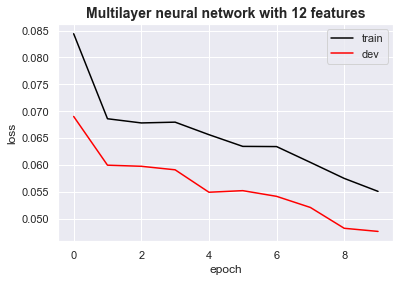

In [38]:
#MODEL 5: One hot encoding using sector specification and gender.  Use the above one-hot encoding.  Model has 12 features in total .

x_columns = ['onehotencoder__Sector_Basic Materials', 'onehotencoder__Sector_Communication Services', 
             'onehotencoder__Sector_Consumer Cyclical', 'onehotencoder__Sector_Consumer Defensive', 
             'onehotencoder__Sector_Energy', 'onehotencoder__Sector_Financial Services', 
             'onehotencoder__Sector_Healthcare', 'onehotencoder__Sector_Industrials', 
             'onehotencoder__Sector_Real Estate', 'onehotencoder__Sector_Technology', 
             'onehotencoder__Sector_Utilities', 'remainder__gender_boolean']

x_columns_mapping = {'onehotencoder__Sector_Basic Materials': "Basic Materials",
                     'onehotencoder__Sector_Communication Services': "Communications Services", 
                     'onehotencoder__Sector_Consumer Cyclical': "Consumer Cyclical", 
                     'onehotencoder__Sector_Consumer Defensive': "Consumer Defensive", 
                     'onehotencoder__Sector_Energy':"Energy", 
                     'onehotencoder__Sector_Financial Services': "Financial Services", 
                     'onehotencoder__Sector_Healthcare': "Healthcare",
                     'onehotencoder__Sector_Industrials' : "Industrials", 
                     'onehotencoder__Sector_Real Estate': "Real Estate",
                     'onehotencoder__Sector_Technology': "Technology", 
                     'onehotencoder__Sector_Utilities': "Utilities"}

y_columns = ['remainder__Total_norm']

model5 = build_model_multi(num_features=12,learning_rate=0.01,hidden_layer_sizes=[256,128])

X = np.asarray(transformed_df[x_columns])
X_test = np.asarray(transformed_df_test[x_columns])
Y = np.asarray(transformed_df[[y_columns]])
Y_test = np.asarray(transformed_df_test[[y_columns]])

#Train the model
history5 = model5.fit(
  x = X,
  y = Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
display(pd.DataFrame(history5.history))


# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model5.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)


show_history(history5,"Multilayer neural network with 12 features")

In [39]:
# Calculating RMSE for model 5
Y_pred = model5.predict(X_test)

print("Y_pred shape:", Y_pred.shape)
# Squeeze Y_pred to remove singleton dimensions
Y_pred = Y_pred[:,0]
print("Y_pred shape:", Y_pred.shape)

# Calculate squared differences for each predicted value
squared_diff = (Y_pred - Y_test) ** 2

# Calculate mean squared error (MSE) for each predicted value
mse = np.mean(squared_diff)

# Calculate root mean squared error (RMSE) for each predicted value
rmse = np.sqrt(mse)

# Calculate average RMSE across all predicted values
average_rmse5 = np.mean(rmse)

print("Average RMSE:", average_rmse5)

84/84 [==============================] - 0s 992us/step
Y_pred shape: (2664, 128)
Y_pred shape: (2664,)
Average RMSE: 0.1729106991931974


1/1 [==============================] - 0s 42ms/step
<function xticks at 0x7f7d72855310>
['Basic Materials', 'Communications Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities']


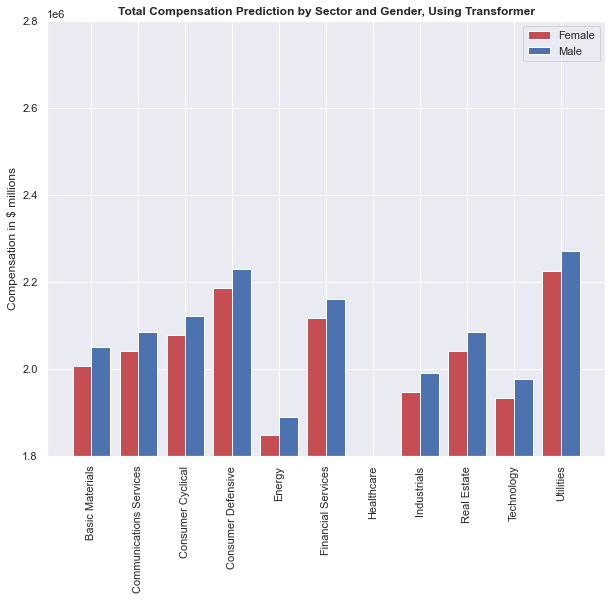

In [40]:
# Save predictions to dataframe, creating values for graphs

model5_predictions = []
for index,column in enumerate(x_columns[:-1]):
  tmp_array = [0]*12
  # gender_bool 0 in first prediction
  tmp_array[index] = 1
  model5_predictions.append([x_columns_mapping[column], "male", unnormalize_total(model5.predict([tmp_array])[0][0])])
  # change the gender at index 11 to female, which is 1
  tmp_array[11] = 1
  model5_predictions.append([x_columns_mapping[column], "female", unnormalize_total(model5.predict([tmp_array])[0][0])])

df_model5_predictions = pd.DataFrame(model5_predictions, columns=['Sector', "Gender", "Total_Compensation"])


# Plotting bar chart with female/male by sector

print(plt.xticks)


female = df_model5_predictions[df_model5_predictions['Gender'] == 'female']
male = df_model5_predictions[df_model5_predictions['Gender'] == 'male']

x_pos = np.arange(len(female))
tick_labels = female.Sector.tolist()
print(tick_labels)

plt.figure(figsize=(10, 8))
plt.bar(x_pos - 0.2, female['Total_Compensation'], width=0.4, label='Female', color = 'r')
plt.bar(x_pos + 0.2, male['Total_Compensation'], width=0.4, label='Male', color ='b')
plt.xticks(ticks =[ 0,  1,  2,  3,  4,  5 , 6,  7,  8,  9, 10], labels=['Basic Materials', 'Communications Services', 'Consumer Cyclical', 'Consumer Defensive', 
                                                'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities'],rotation = 'vertical')
plt.ylabel ("Compensation in $ millions")
plt.title ("Total Compensation Prediction by Sector and Gender, Using Transformer", fontweight = 'bold')
plt.ylim(1800000, 2800000)
plt.legend()
plt.show()



## Comparing models using Root Mean Square Error

We found that the L2 ridge model is the most accurate, indicating that ormalization yielded greater predicted power than additional layers or features. 

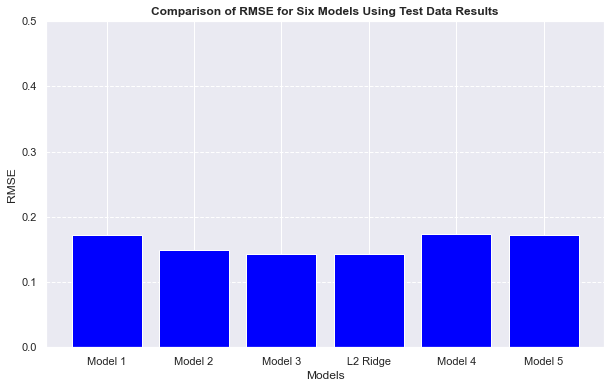

In [41]:
# List of model names
model_names = ['Model 1', 'Model 2', 'Model 3', 'L2 Ridge', 'Model 4', 'Model 5']

# : One Feature, One Layer, : One Layer, Two Features, : Multilayer, Two Features, : Multilayer, Two Features,: Multilayer, 12 Features
# List of RMSE values for each model
rmse_values = [average_rmse1, average_rmse2, average_rmse3, average_rmse_ridge, average_rmse4, average_rmse5]

# Create a bar plot for RMSE values
plt.figure(figsize=(10, 6))  
plt.bar(model_names, rmse_values, color='blue')  
plt.xlabel('Models')  
plt.ylabel('RMSE')  
plt.title('Comparison of RMSE for Six Models Using Test Data Results', fontweight = "bold")  
plt.ylim(0, 0.5)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis
plt.show()  # Display the plot

# Section 5: Ethical Considerations 


Several ethical considerations arose during our problem definition and analysis, both in terms of the constraints and specifics of the scope of this project and the broader implications of using machine learning to understand and predict pay and barriers to pay equity. In our dataset, there was a limited sample size of female executives. The SEC data has a limited number of female executives relative to male executives, particularly in specific sectors or companies where women are especially underrepresented in leadership positions. This can make it difficult to draw meaningful conclusions about gender pay disparities at the executive level and may lead to underestimating the extent of the problem. The SEC data focuses primarily on executive compensation, which is not reflective of the compensation differences amongst employee groups at different levels of seniority, particularly those in lower-level positions who may be more vulnerable to pay disparities. The models are not well-suited to deployment in contexts related to non-executive compensation. An additional fairness concern stems from using genderize.io to add in assumed gender. 

In a study from 2021, the NIH found a significant number of nonclassifications (16.4%), mainly when testing in more multicultural contexts. In our usage, the approach was to drop names where Genderize.io is inconclusive, raising concerns about removing data from the sample in a biased way. This generally removed individuals from the sample where an initial was listed for the individual’s first name. We also dropped anyone with a salary below $100k from the sample. Using Genderize.io additionally risks marginalizing some individuals who do not recognize themselves in the binary differentiation. Caution and safety checks are needed to avoid encoding or potentially exacerbating bias against people of specific gender identities, particularly with more complex models that lack explainability. 

For using machine learning outside of specific contexts where salary transparency and total pay disclosure are clearly established, it is vital to adhere to requirements around consent and stringent PII protections, which frequently change due to the increased ability to identify someone based on limited information. Though executives of public companies are subject to pay disclosures, we found discrepancies in the SEC data that risked misrepresenting the state of pay equity and perpetuating inaccuracies related to individual compensation. Overall, advancements in machine learning techniques can represent a significant opportunity to improve understanding of and solutions to addressing barriers to pay equity; however, without careful consideration, they can risk exacerbating the inequities they can help address, particularly in situations where accountability is unestablished.





# Section 6: Conclusions

Using publically available data on executive compensation, our models, ranging from simple regression to multi-featured, multilayer neural networks, consistently predict that male executives outperform female executives.
Some observational studies show that in some positions and sectors, some women outearn their male counterparts, but our machine-learning models do not support this.


We acknowledge the limitations of our research; data quality is an issue, and pulling raw data from SEC filings does not yield a clean data set. We noted several discrepancies and problems in our data cleaning. Finally, the data does not give a complete picture, as there needs to be more information on the length of tenure and family situation. 

There are several areas for further research. For example, machine learning techniques could be used to predict the success of different pay equity initiatives. Machine learning tools could be used to predict women's ascent to the C-suite within different organizations, industries, and sectors.
